<a href="https://colab.research.google.com/github/Kyrylo-Bakumenko/CT_Scan_Detection/blob/main/Medical_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Imports and Settings
LOCAL_RUNNTIME = True
SKIP_FULLBODY = True
# general
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
# image handling
import cv2
from PIL import Image, ImageOps
# from google.colab.patches import cv2_imshow
# model
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.nn.functional import softmax
# filesystem
import pickle
# from google.colab import drive
from os import listdir

# mount google drive or connect to local OS
if(not LOCAL_RUNNTIME):
  drive.mount('/content/drive/')
  PRE_PATH = '/content/drive/My Drive/Medical_Files/'
  %cd PRE_PATH
  !ls
else:
  PRE_PATH = 'E:/COLAB_PROJECTS/Medical_Notebook/'

# quality of life
pd.set_option('display.float_format', lambda x: '%.5f' % x)

### Variables ###
PICKLED = False
CATEGORIES = ['Normal','Cyst','Tumor', 'Stone']
# resnet architecture expects 224 dim and 3channels
DIM = 224
TRAIN_PCT = 0.6

In [ ]:
#@title Custom ResNet
class block(nn.Module):
  def  __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
    super(block, self).__init__()
    self.expansion = 4
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
    self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
    self.relu = nn.ReLU()
    self.identity_downsample = identity_downsample
  
  def forward(self, x):
    identity = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.conv3(x)
    x = self.bn3(x)

    if self.identity_downsample is not None:
      identity = self.identity_downsample(identity)

    x += identity
    x = self.relu(x)
    return x

class ResNet(nn.Module): # [3, 4, 6, 3] for 50 layer depth
  def __init__(self, block, layers, image_channels, num_classes):
    super(ResNet, self).__init__()
    self.in_channels = 64
    self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # ResNet layers
    self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
    self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
    self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
    self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2) # 2048 at the end

    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    # ends in fullyconnected layer
    self.fc = nn.Linear(512*4, num_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    # resnet layers
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    # make correct shape (output 1 by 1)
    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fc(x)

    return x

  def _make_layer(self, block, num_residual_blocks, out_channels, stride):
    identity_downsample = None
    layers = []

    if stride != 1 or self.in_channels != out_channels * 4:
      identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, 
                                                    out_channels*4, 
                                                    kernel_size=1, 
                                                    stride=stride),
                                          nn.BatchNorm2d(out_channels*4))
      
    # tricky part
    layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
    self.in_channels = out_channels*4

    for i in range(num_residual_blocks - 1):
      layers.append(block(self.in_channels, out_channels))
      # 256 -> 64 -> 64*4 = 256 (again), (stride 1)
      # 


    return nn.Sequential(*layers)

# Define various depth resnets
# layers sourced from authors' paper
def ResNet50(img_channels=3, num_classes=4):
  return ResNet(block, [3,4,6,3], img_channels, num_classes)

def ResNet101(img_channels=3, num_classes=4):
  return ResNet(block, [3,4,23,3], img_channels, num_classes)

def ResNet152(img_channels=3, num_classes=4):
  return ResNet(block, [3,8,36,3], img_channels, num_classes)

def test():
  net = ResNet50()
  x = torch.randn(2, 3, 224, 224)
  y = net(x).to('cuda')
  print(y.shape)
  net = ResNet101()
  x = torch.randn(2, 3, 224, 224)
  y = net(x).to('cuda')
  print(y.shape)
  net = ResNet152()
  x = torch.randn(2, 3, 224, 224)
  y = net(x).to('cuda')
  print(y.shape)


In [ ]:
#@title Load Data
# import kindey data
kd = pd.read_csv(PRE_PATH + 'kidneyData.csv', header=0, usecols=['image_id', 'path', 'Class', 'target'])
# set relative path from absolute
name_length = len('/content/data/CT KIDNEY DATASET Normal, CYST, TUMOR and STONE/')
for path in range(len(kd)):
  kd.loc[path, 'path'] = kd.loc[path, 'path'][name_length:]
# shuffle the DataFrame rows
kd = kd.sample(frac = 1)
# subsection into training and testing datasets
idx = int(TRAIN_PCT * len(kd))
kd_train = kd.iloc[:idx]
kd_test = kd.iloc[idx:]
# kd is a table refrencing image_id to Class
print(f'Training dataset size: {len(kd_train)}')
print(f'Testing dataset size: {len(kd_test)}')
print(f'Verify... {len(kd_train)} + {len(kd_test)} = {len(kd)} : {len(kd_train) + len(kd_test) == len(kd)}')

kd_train.head()

Training dataset size: 7467
Testing dataset size: 4979
Verify... 7467 + 4979 = 12446 : True


,image_id,path,target,Class
3908,Normal- (4897),NORMAL/Normal- (4897).jpg,1,Normal
7615,Stone- (859),STONE/Stone- (859).jpg,2,Stone
1731,Tumor- (568),TUMOR/Tumor- (568).jpg,3,Tumor
7812,Stone- (607),STONE/Stone- (607).jpg,2,Stone
8023,Stone- (458),STONE/Stone- (458).jpg,2,Stone


In [ ]:
#@title Setup Training and Testing Data, 
# declare img arrays
train_set = np.ndarray(shape=(len(kd_train), DIM, DIM, 3), dtype=np.uint8)
test_set = np.ndarray(shape=(len(kd_test), DIM, DIM, 3), dtype=np.uint8)
train_removed_idx = []
test_removed_idx = []
del kd

pre_path = PRE_PATH + 'CT-KIDNEY-DATASET/'
# if data not present, process images from drive
if not PICKLED:
  img_count = 0
  print('\nLoading images for training...\n')
  for path in tqdm(kd_train['path']):
    img = cv2.imread(pre_path + path)
    # if not 512x512 local scan, skip
    if SKIP_FULLBODY:
      h, w = img.shape[:2]
      if h != 512 or w != 512:
        train_removed_idx.append(img_count)
        img_count += 1
        continue
    # resize to DIM
    resize = cv2.resize(img, (DIM, DIM), cv2.INTER_AREA)
    # # greyscale from redundant 3-channel
    # grey = cv2.cvtColor(resize, cv2.COLOR_BGR2GRAY)
    train_set[img_count] = resize
    img_count += 1

  # pickle data, manage RAM
  # update with removed indexes
  train_set = np.delete(train_set, train_removed_idx, axis=0)
  np.save(PRE_PATH + 'ct_kidney_training_data.npy', train_set)
  del train_set

  img_count = 0
  print('\nLoading images for testing...\n')
  for path in tqdm(kd_test['path']):
    img = cv2.imread(pre_path + path)
    # if not 512x512 local scan, skip
    if SKIP_FULLBODY:
      h, w = img.shape[:2]
      if h != 512 or w != 512:
        test_removed_idx.append(img_count)
        img_count += 1
        continue
    # resize to DIM
    resize = cv2.resize(img, (DIM, DIM), cv2.INTER_AREA)
    # # greyscale from redundant 3-channel
    # grey = cv2.cvtColor(resize, cv2.COLOR_BGR2GRAY)
    test_set[img_count] = resize
    img_count += 1

  # pickle data, manage RAM
  # update with removed indexes
  test_set = np.delete(test_set, test_removed_idx, axis=0)
  np.save(PRE_PATH + 'ct_kidney_testing_data.npy', test_set)
  del test_set

  # pickle data
  train_labels = np.zeros((len(kd_train), 4))
  for i in range(len(kd_train)):
    train_labels[i][kd_train.iloc[i, 2]] = 1
  # update with removed indexes
  train_labels = np.delete(train_labels, train_removed_idx, axis=0)
  test_labels = np.zeros((len(kd_test), 4))
  for i in range(len(kd_test)):
    test_labels[i][kd_test.iloc[i, 2]] = 1
  # update with removed indexes
  test_labels = np.delete(test_labels, test_removed_idx, axis=0)
  np.save(PRE_PATH + 'ct_kidney_training_labels.npy', train_labels)
  np.save(PRE_PATH + 'ct_kidney_testing_labels.npy', test_labels)
  PICKLED = True


  0%|                                                                                 | 3/7467 [00:00<04:21, 28.57it/s]


Loading images for training...



  0%|                                                                                 | 6/4979 [00:00<01:32, 53.52it/s]


Loading images for testing...



100%|██████████████████████████████████████████████████████████████████████████████| 4979/4979 [01:50<00:00, 45.01it/s]


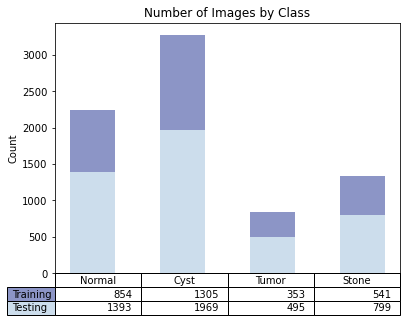

In [ ]:
#@title Data Visualization (pre-augmentation)
data = np.ndarray( (2, len(CATEGORIES)) )

columns = CATEGORIES
rows = ['Training', 'Testing']

#cyst, normal, stone, tumor counts
counts = np.zeros((4))
for label in train_labels.argmax(axis=1):
  counts[label] += 1
# fill in counts for train_set
for i in range(len(columns)):
  data[0][i] = counts[i]
counts = np.zeros((4))
for label in test_labels.argmax(axis=1):
  counts[label] += 1
# fill in counts for test_set
for i in range(len(columns)):
  data[1][i] = counts[i]

values = np.arange(0, data.max(axis=1).sum(), 500)

# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0.2, 0.5, len(rows)))
n_rows = len(data)

index = np.arange(len(columns))
bar_width = 0.5

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(columns))

# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    plt.bar(index, data[row], bar_width, bottom=y_offset, color=colors[row])
    y_offset = y_offset + data[row]
    cell_text.append(['%1.0f' % x for x in data[row]])
# Reverse colors and text labels to display the last value at the top.
colors = colors[::-1]
cell_text.reverse()

# Add a table at the bottom of the axes
the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      colLabels=columns,
                      loc='bottom')

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.1, bottom=0.01)

plt.ylabel("Count")
plt.yticks(values, ['%d' % val for val in values])
plt.xticks([])
plt.title('Number of Images by Class')

plt.show()

In [ ]:
#@title Image Manipulation Helper Methods
def rotated_array(arr, theta):
  # get PIL image
  img = Image.fromarray(np.uint8(arr))
  # rotate by theta degrees
  img = img.rotate(theta)
  # return back as numpy array
  return np.asarray(img)

def random_crop(arr, max_offset_ratio=0.1):
  # get PIL image
  img = Image.fromarray(np.uint8(arr))
  # calculate random offset from image dimensions
  w, h = img.size
  random_range = int(min(w, h)*max_offset_ratio)
  offset_x = np.random.randint(low=1, high=1+random_range)
  offset_y = np.random.randint(low=1, high=1+random_range)
  # crop image
  left = offset_x/2
  top = offset_y/2
  right = w-offset_x/2
  bottom = h-offset_y/2
  img = img.crop((left, top, right, bottom))
  # resize to required dimensions
  img = img.resize((DIM, DIM))
  # return numpy array
  return np.asarray(img)

def mirror(arr):
  # get PIL image
  img = Image.fromarray(np.uint8(arr))
  # mirror
  img = ImageOps.mirror(img)
  # return numpy array
  return np.asarray(img)

augmenting training data . . .
-20
-10
0
10
20
augmenting testing data . . .
-20
-10
0
10
20


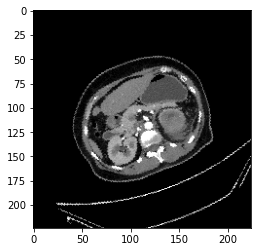

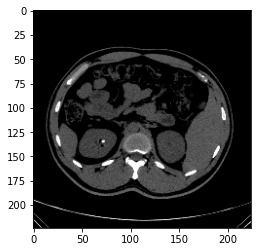

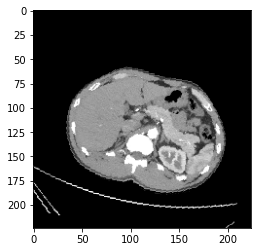

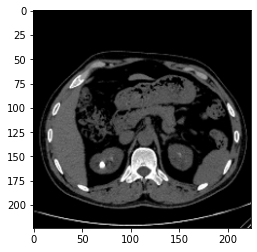

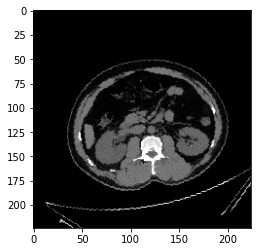

In [ ]:
#@title Data Augmentation
# as per author's recommendations:
# "a combination of our method of over-sampling the minority class and
# under-sampling the majority class can achieve better classifier performance"
# https://arxiv.org/abs/1106.1813
# Note: because SMOTE is only aware of the minor classs,
# it will no tbe used to avoid ambiguity with major classes

#@title Un-pickle
# un-pickle data
path = ''
if(LOCAL_RUNNTIME): path = PRE_PATH
train_set = np.load(path + 'ct_kidney_training_data.npy')
train_labels = np.load(path + 'ct_kidney_training_labels.npy')


# 1. Over-sampling minority class

# to help aid against over-fitting, add in various modifications to data
# max length is 3274
# min length is 848 
aug_factor = 8
new_train_set = np.ndarray(shape=(len(train_set)*aug_factor, DIM, DIM, 3), dtype=np.uint8)
idx = 0
print('augmenting training data . . .')
# add rotated images (both directions)
max_theta = 20
delta_theta = 10
# note: when passing 0, this copies original train_set
for theta in range(-max_theta, max_theta+delta_theta, delta_theta):
  for i in range(len(train_set)):
    new_train_set[idx] = rotated_array(train_set[i], theta)
    idx+=1

# add random crop images
num_crops = 2
for crop in range(num_crops):
  for i in range(len(train_set)):
    new_train_set[idx] = random_crop(train_set[i])
    idx+=1

# mirror all entries
for i in range(len(train_set)):
  new_train_set[idx] = mirror(train_set[i])
  idx+=1

# now extend label to match
new_train_labels = np.zeros((len(train_labels)*aug_factor, 4))
for i in range(len(train_labels)):
  for j in range(aug_factor):
    new_train_labels[j*len(train_labels) + i] = train_labels[i]

# 2. Under-sampling majority class
c_idxs = []
n_idxs = []
s_idxs = []
t_idxs = []

class_idxs = new_train_labels.argmax(axis=1)
for i in range(len(new_train_labels)):
  if class_idxs[i] == 0: c_idxs.append(i)
  elif class_idxs[i] == 1: n_idxs.append(i)
  elif class_idxs[i] == 2: s_idxs.append(i)
  elif class_idxs[i] == 3: t_idxs.append(i)

# balance class sizes
# "best lift index is obtained when the classes are equally represented"
# (Ling & Li, 1998) using lift curve, similar to ROC, quoted from same paper
idxs_to_remove = []
min_class_size = min(len(c_idxs), len(n_idxs), len(s_idxs), len(t_idxs))
for idx in random.sample(c_idxs, len(c_idxs)-min_class_size):
  idxs_to_remove.append(idx)
for idx in random.sample(n_idxs, len(n_idxs)-min_class_size):
  idxs_to_remove.append(idx)
for idx in random.sample(s_idxs, len(s_idxs)-min_class_size):
  idxs_to_remove.append(idx)
for idx in random.sample(t_idxs, len(t_idxs)-min_class_size):
  idxs_to_remove.append(idx)

new_train_set = np.delete(new_train_set, idxs_to_remove, axis=0)
new_train_labels = np.delete(new_train_labels, idxs_to_remove, axis=0)

# pickle them 
np.save(PRE_PATH + 'ct_kidney_training_data.npy', new_train_set)
np.save(PRE_PATH + 'ct_kidney_training_labels.npy', new_train_labels)
# delete to save RAM
del new_train_set
del new_train_labels

############################################
###     repeat with validation data     ####
############################################

test_set = np.load(path + 'ct_kidney_testing_data.npy')
test_labels = np.load(path + 'ct_kidney_testing_labels.npy')

new_test_set = np.ndarray(shape=(len(test_set)*aug_factor, DIM, DIM, 3), dtype=np.uint8)
idx = 0
print('augmenting testing data . . .')
# add rotated images (both directions)
max_theta = 20
delta_theta = 10
# note: when passing 0, this copies original test_set
for theta in range(-max_theta, max_theta+delta_theta, delta_theta):
  for i in range(len(test_set)):
    new_test_set[idx] = rotated_array(test_set[i], theta)
    idx+=1

# add random crop images
num_crops = 2
for crop in range(num_crops):
  for i in range(len(test_set)):
    new_test_set[idx] = random_crop(test_set[i])
    idx+=1

# mirror all entries
for i in range(len(test_set)):
  new_test_set[idx] = mirror(test_set[i])
  idx+=1

# now extend label to match
new_test_labels = np.zeros((len(test_labels)*aug_factor, 4))
for i in range(len(test_labels)):
  for j in range(aug_factor):
    new_test_labels[j*len(test_labels) + i] = test_labels[i]

# 2. Under-sampling majority class
c_idxs = []
n_idxs = []
s_idxs = []
t_idxs = []

class_idxs = new_test_labels.argmax(axis=1)
for i in range(len(new_test_labels)):
  if class_idxs[i] == 0: c_idxs.append(i)
  elif class_idxs[i] == 1: n_idxs.append(i)
  elif class_idxs[i] == 2: s_idxs.append(i)
  elif class_idxs[i] == 3: t_idxs.append(i)

# balance class sizes
idxs_to_remove = []
min_class_size = min(len(c_idxs), len(n_idxs), len(s_idxs), len(t_idxs))
for idx in random.sample(c_idxs, len(c_idxs)-min_class_size):
  idxs_to_remove.append(idx)
for idx in random.sample(n_idxs, len(n_idxs)-min_class_size):
  idxs_to_remove.append(idx)
for idx in random.sample(s_idxs, len(s_idxs)-min_class_size):
  idxs_to_remove.append(idx)
for idx in random.sample(t_idxs, len(t_idxs)-min_class_size):
  idxs_to_remove.append(idx)

new_test_set = np.delete(new_test_set, idxs_to_remove, axis=0)
new_test_labels = np.delete(new_test_labels, idxs_to_remove, axis=0)

# pickle them 
np.save(PRE_PATH + 'ct_kidney_testing_data.npy', new_test_set)
np.save(PRE_PATH + 'ct_kidney_testing_labels.npy', new_test_labels)

# Show Sample Augmentations
for i in range(5):
  rand = np.random.randint(0, len(new_test_set))
  plt.imshow(np.uint8(new_test_set[rand]))
  plt.show()

# delete to save RAM
del new_test_set
del new_test_labels


In [ ]:
#@title Un-pickle
# un-pickle data
path = ''
if(LOCAL_RUNNTIME): path = PRE_PATH
train_set = np.load(path + 'ct_kidney_training_data.npy')
train_labels = np.load(path + 'ct_kidney_training_labels.npy')
test_set = np.load(path + 'ct_kidney_testing_data.npy')
test_labels = np.load(path + 'ct_kidney_testing_labels.npy')

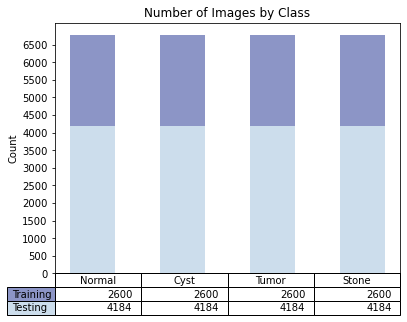

In [ ]:
#@title Data Visualization (post-augmentation)
data = np.ndarray( (2, len(CATEGORIES)) )

columns = CATEGORIES
rows = ['Training', 'Testing']

#cyst, normal, stone, tumor counts
counts = np.zeros((4))
for label in train_labels.argmax(axis=1):
  counts[label] += 1
# fill in counts for train_set
for i in range(len(columns)):
  data[0][i] = counts[i]
counts = np.zeros((4))
for label in test_labels.argmax(axis=1):
  counts[label] += 1
# fill in counts for test_set
for i in range(len(columns)):
  data[1][i] = counts[i]

values = np.arange(0, data.max(axis=1).sum(), 500)

# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0.2, 0.5, len(rows)))
n_rows = len(data)

index = np.arange(len(columns))
bar_width = 0.5

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(columns))

# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    plt.bar(index, data[row], bar_width, bottom=y_offset, color=colors[row])
    y_offset = y_offset + data[row]
    cell_text.append(['%1.0f' % x for x in data[row]])
# Reverse colors and text labels to display the last value at the top.
colors = colors[::-1]
cell_text.reverse()

# Add a table at the bottom of the axes
the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      colLabels=columns,
                      loc='bottom')

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.1, bottom=0.01)

plt.ylabel("Count")
plt.yticks(values, ['%d' % val for val in values])
plt.xticks([])
plt.title('Number of Images by Class')

plt.show()

In [ ]:
#@title Combine Images and Class Type
# rework to torch tensors for pytorch compatible efficiency
# X -> image data
# y -> label data
train_X = torch.Tensor([i for i in train_set]).view(-1, 224, 224, 3)
print("X shape: ", train_X.shape)
del train_set
test_X = torch.Tensor([i for i in test_set]).view(-1, 224, 224, 3)
print("X shape: ", test_X.shape)
del test_set

train_y = torch.Tensor([i for i in train_labels])
test_y = torch.Tensor([i for i in test_labels])
print("y shape: ", test_y.shape)
print("y shape: ", train_y.shape)

# save ram
del train_labels
del test_labels

X shape:  torch.Size([16736, 224, 224, 3])
X shape:  torch.Size([10400, 224, 224, 3])
y shape:  torch.Size([10400, 4])
y shape:  torch.Size([16736, 4])


In [ ]:
#@title Pickle Tensors
def save_large_tensor(data, path, splits=100, protocal=pickle.HIGHEST_PROTOCOL):
  tensor_length = len(data)
  split_length = tensor_length//splits
  idx = 0
  if split_length > 0:
    for split in range(splits):
      torch.save(data[idx:idx+split_length], path + f'_{split}', pickle_protocol=protocal)
      idx += split_length
  
  torch.save(data[idx:], path + f'_{splits}', pickle_protocol=protocal)
  # torch.save(tensor_length, path + 'tensor_length', pickle_protocol=protocal)

# Pickle Tensors
path = ''
if(LOCAL_RUNNTIME): path = PRE_PATH
save_large_tensor(train_X, path + 'ct_kidney_training_data.pt', protocal=pickle.HIGHEST_PROTOCOL)
torch.save_large_tensor(test_X, path + 'ct_kidney_testing_data.pt', protocal=pickle.HIGHEST_PROTOCOL)
torch.save(train_y, path + 'ct_kidney_training_labels.pt')
torch.save(test_y, path + 'ct_kidney_testing_labels.pt')

In [ ]:
len(train_X)//100

167

In [ ]:
#@title [SKIP HERE IF TENSORS-PICKLED] Un-pickle Tensors

def load_large_tensor(data, path, splits=10):
  tensor_1 = torch.load(path + '_0')
  for split in range(1,splits+1):
    tensor_2 = torch.load(path + f'_{split}')
    tensor_1 = torch.cat((tensor_1, tensor_2), dim=0)
  
  return tensor_1

path = ''
if(LOCAL_RUNNTIME): path = PRE_PATH
train_X = torch.load(path + 'ct_kidney_training_data.pt')
test_X = torch.load(path + 'ct_kidney_testing_data.pt')
train_y = torch.load(path + 'ct_kidney_training_labels.pt')
test_y = torch.load(path + 'ct_kidney_testing_labels.pt')

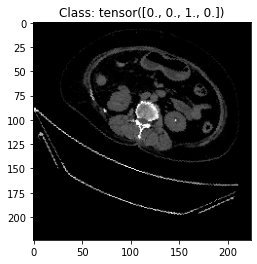

In [ ]:
plt.imshow(np.uint8(train_X[0]));
plt.title(f'Class: {train_y[0]}')
plt.show()

In [ ]:
#@title Instantiate Model
# GPU override     [  not enough VRAM  ]
USE_GPU = True
# check for GPU availability
if USE_GPU:
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
  device = torch.device("cpu")

net = ResNet152()
if USE_GPU and torch.cuda.is_available():
    net.to(device)

# resnet152 = models.resnet152(pretrained=False)
# resnet152.to(device)
# optimizer = optim.Adam(resnet152.parameters(), lr=0.001)

# Authors recommend SGD
# optimizer = optim.SGD(net.parameters(), lr=0.001)
# loss_function = nn.MSELoss()
checkpoint = torch.load('E:/COLAB_PROJECTS/Medical_Notebook/Backup_Models/Augmented Dataset/CT_Model_Resnet152_Epoch12_0.911.pt')
net.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

<All keys matched successfully>

In [ ]:
train_X.size()

torch.Size([16736, 224, 224, 3])

In [ ]:
def find_lr(net, device, BATCH_SIZE=16, lr_lower=10e-9, lr_upper=10e-1, growth_rate=1.2):
  # set model to training (useing gradient)
  net.train()
  # decalre loss function
  loss_function = nn.MSELoss()
  # initialize lr (starting at lower bound)
  lr = lr_lower
  # create list to store loss vs LR data
  loss_insample = []
  lr_historical = []

  # for computing a smoothed, average loss
  beta_value = 0.98
  avg_loss = 0
  batch_num = 0

  for i in range(0, len(train_X), BATCH_SIZE):
    if(lr > lr_upper): break
    # LR, optimizer
    optimizer = optim.SGD(net.parameters(), lr=lr)
    # if i % 50 == 0: print(f'\nTraining... LR={lr}')
    # run the model
    batch_X = train_X[i:i+BATCH_SIZE].view(-1, 3, 224, 224)
    batch_y = train_y[i:i+BATCH_SIZE]
    
    if USE_GPU: batch_X, batch_y = batch_X.to(device), batch_y.to(device)
    
    net.zero_grad()
    outputs = net(batch_X)
    loss = loss_function(outputs, batch_y)
    # avg and smooth loss
    batch_num += 1
    avg_loss = (beta_value * avg_loss) + ((1 - beta_value) * loss)
    smooth = avg_loss / (1 - (beta_value ** batch_num))
    # append data
    loss_insample.append(smooth)
    lr_historical.append(lr)
    # update model
    loss.backward()
    optimizer.step()
    lr *= 1.05
  
  return loss_insample, lr_historical

In [ ]:
### I need to attempt to run find_lr multiple times (say 10) to check if weights
### are randommized upon creation
# this would result in different LR curves, form which I can then take
# 10% and 90% quartiles as well as avg for visualization
def lr_range_test(net, device, sim_count=5):
  loss_avg = []
  lrs = []
  # simulate range tests
  for i in tqdm(range(sim_count)):
    net = ResNet152()
    if USE_GPU and torch.cuda.is_available(): net.to(device)
    loss, lr = find_lr(net, device)
    loss_avg.append(loss)
    lrs.append(lr)
  # create arrays for percentile data
  loss_avg = np.asanyarray(loss_avg)
  loss_90 = np.ndarray((len(loss_avg[0])), dtype=np.float16)
  loss_10 = np.ndarray((len(loss_avg[0])), dtype=np.float16)
  # find 10% and 90% percentile for every lr
  for i in range((len(loss_avg[0]))):
    loss_90[i] = np.percentile(loss_avg[:, i], 90)
    loss_10[i] = np.percentile(loss_avg[:, i], 10)
  # return data
  return loss_avg, loss_10, loss_90, lrs

In [ ]:
loss_avg, loss_10, loss_90, lrs = lr_range_test(net, device)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [13:24<00:00, 160.96s/it]


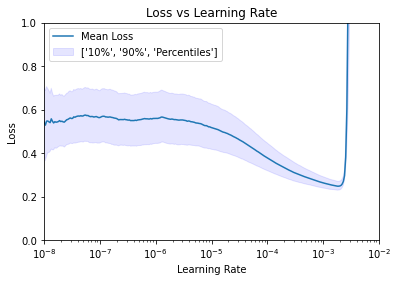

In [ ]:
#@title Determining Learning Rate and Policy
# Dr. Smith, https://arxiv.org/pdf/1506.01186.pdf

# Learning Rate Range Test
# loss_insample, lr_historical = find_lr(net)
loss_avg_y = np.mean(loss_avg, axis=0)
lrs_x = lrs[0]
# plot loss vs LR
fig, ax = plt.subplots()
ax.plot(lrs_x, loss_avg_y,  label='Mean Loss')
ax.fill_between(lrs_x, loss_10, loss_90, color='b', alpha=.1, label=["10%", "90%", "Percentiles"])
# plt.yscale('log')
plt.xscale('log')
plt.ylim(0,1)
plt.xlim(10e-9,10e-3)
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Learning Rate');

# decide between CLR and Learning Rate schedule with decay


In [ ]:
#@title Implement Cyclical Learning Rate


In [ ]:
#@title Training the Model

EPOCHS = 36
# as per ResNet authors, min_batch >= 256
# however our dataset is much smaller
# vram cannot manage more than batchsize of 16
BATCH_SIZE = 16

loss_outsample = []
acc = []
loss_insample = []

max_accuracy = 0
min_loss = 10

optimizer = optim.SGD(net.parameters(), lr=10e-4)
loss_function = nn.MSELoss()

resnet152_model_max = net

for epoch in tqdm(range(EPOCHS)):
    net.train()
    print('\nTraining...')
    for i in range(0, len(train_X), BATCH_SIZE):
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 3, 224, 224)
        batch_y = train_y[i:i+BATCH_SIZE]
        
        if USE_GPU: batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
        # del batch_X
        # del batch_y
        # torch.cuda.empty_cache()

    
    correct = 0
    total = 0
    mean_loss = 0
    
    net.eval()
    with torch.no_grad():
        print('\nValidation...')
        for i in range(len(test_X)):
            real_class = torch.argmax(test_y[i]).to(device)
            model_out = net(test_X[i].view(-1, 3, 224, 224).to(device))[0]
            predicted_class = torch.argmax(model_out)
#             print(predicted_class, real_class)
            loss_test = loss_function(model_out, test_y[i].to(device))
            mean_loss += loss_test
            if predicted_class == real_class:
                correct += 1
            total += 1
    accuracy = round(correct/total, 3)
    acc.append(accuracy)
    print("Out/Sample Accuracy: ", accuracy)
    loss_outsample.append(loss_test)
    loss_insample.append(loss)
#     mean_loss = mean_loss/(len(test_X)) ### for clarity in graph ###
    torch.save({
        'epoch': epoch,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'accuracy': accuracy,
    }, f'E:/COLAB_PROJECTS/Medical_Notebook/CT_Model_Resnet152_current.pt')
    print("In/Loss: ", loss)
    print("Out/Loss: ", mean_loss)
    if accuracy > max_accuracy or ( accuracy == max_accuracy and (loss < min_loss) ):
        max_accuracy = accuracy
        min_loss = loss
        resnet152_model_max = net
        torch.save({
        'model_state_dict': resnet152_model_max.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': min_loss,
        'accuracy': max_accuracy,
        },f'E:/COLAB_PROJECTS/Medical_Notebook/CT_Model_Resnet152_best-{str(max_accuracy).replace(".", "_")}.pt')


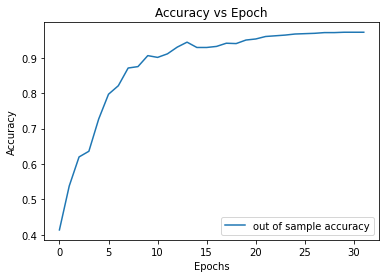

In [ ]:
plt.plot(acc, label='out of sample accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()

plt.show()

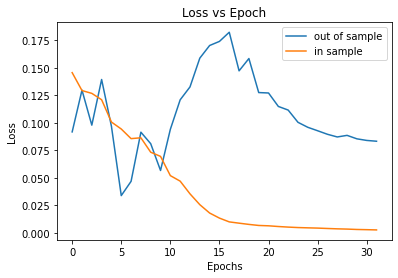

In [ ]:
plt.plot(loss_outsample, label='out of sample')
plt.plot(loss_insample, label='in sample')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()

plt.show()

In [ ]:
#@title Deal with VRAM
def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
												   type(obj.data).__name__, 
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)

In [ ]:
dump_tensors()

In [ ]:
tpr[0]

array([0.        , 0.96774194, 1.        ])

In [ ]:
#@title ROC-AUC Curves
from sklearn.metrics import roc_curve, auc, confusion_matrix

n_classes = 4
length = len(test_X)

# if 'proba' not in locals() or 'proba' not in globals():
net.to('cpu');
net.eval()
logits = np.ndarray((length, 4))
with torch.no_grad():
  print('Pass data into model...')
  for i in tqdm(range(length)):
    logits[i] = net(test_X[i].view(-1, 3, 224, 224))
# del test_X
# probs = nn.functional.softmax(logits, dim=1) # assuming logits has the shape [batch_size, nb_classes]
probs = logits.argmax(axis=1)
# from singleton array to OHE
proba = np.zeros((len(probs), probs.max()+1))
# del probs
proba[np.arange(len(proba)), probs] = 1

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
print('Calculate ROC...')
for i in tqdm(range(n_classes)):
  with torch.no_grad():
    fpr[i], tpr[i], _ = roc_curve(test_y[0:length, i], proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()

    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{CATEGORIES[i]}')
    plt.legend(loc="lower right")
    plt.show()

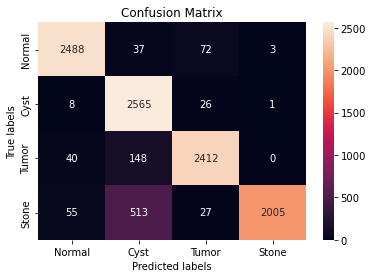

In [23]:
#@title Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

ax = plt.subplot()

cm = confusion_matrix(np.asarray(test_y[0:length]).argmax(axis=1), np.asarray(probs)[0:length])
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

lables = CATEGORIES   
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(lables); ax.yaxis.set_ticklabels(lables);

In [ ]:
#@title Helper Functions
# black out and white out
def region_cover(arr, x, y, window_size=1):
  black_out = np.copy(arr)
  white_out = np.copy(arr)
  offset = (window_size-1) // 2
  w = len(arr)
  h = len(arr[0])
  # ensure xi and yi stay within bounds
  xmin = max(x-offset, 0)
  xmax = min(x+offset, w-1)
  ymin = max(y-offset, 0)
  ymax = min(y+offset, h-1)
  # +1's because of half interval nature of range
  for xi in range(xmin, xmax+1):
    for yi in range(ymin, ymax+1):
      # set all channels at pizel location to white/black
      for ci in range(len(arr[xi][yi])):
        black_out[xi][yi][ci] = 0
        white_out[xi][yi][ci] = 255
        
  return torch.Tensor(black_out), torch.Tensor(white_out)


def add_weighted(src1, weight1, src2, weight2, c_map=[1., .5, .2]):
  if src1.shape != src2.shape:
    print("AAAAAAH")
    return
  w, h, c = src1.shape
  res = src1
  for x in range(w):
    for y in range(h):
      for i in range(c):
        res[x][y][i] = src1[x][y][i]*weight1 + src2[x][y][i]*weight2*c_map[i]

  return res

In [ ]:
#@title Where is the Model Looking?
# 1. gather randoms ample of images from validation set
# 2. feed into model, a sliding window blocking sections of the image
# 3. the difference between covered and uncovered result vectors
#    will represent the model's sensitivity to that region  
from scipy.spatial.distance import cdist

# sample size, how many masks will be observed
sample_size = 20
window_size = 3

# create mask arrays for test images
masks = np.zeros((sample_size, DIM, DIM, 3))
predicted_labels = np.ndarray((sample_size))

# random sample of sample_size
sample_idxs = np.random.randint(0, len(test_X), sample_size)
sample_x = test_X[sample_idxs]
sample_y = test_y[sample_idxs].argmax(axis=1)

# load a model if not done so already
net.to(device)
net.eval()
with torch.no_grad():
  for i in tqdm(range(sample_size)):
    # apply softmax so that output array sums to one
    real_res = softmax(net(sample_x[i].view(1, 3, 224, 224).to(device)), dim=1)
    real_res = real_res.cpu().numpy()
    # add prediction to predicted labels
    predicted_labels[i] = real_res.argmax()
    for x in range(0,DIM,window_size):
      for y in range(0,DIM,window_size):
        black_out, white_out = region_cover(sample_x[i], x, y, window_size=window_size)
        bo_res = softmax(net(black_out.view(1, 3, 224, 224).to(device)), dim=1)
        wo_res = softmax(net(white_out.view(1, 3, 224, 224).to(device)), dim=1)
        
        bo_res = bo_res.cpu().numpy()
        wo_res = wo_res.cpu().numpy()
        # take error to be square of the difference of output
        # consider the maximum error between white_out/black_out variants 
        error = max(np.square(real_res - bo_res).sum(axis=1),
                    np.square(real_res - wo_res).sum(axis=1))
        # normalize to 0-255 range
        # error = int((error/2)*255)
        # add this value into mask array
        for xi in range(max(x-window_size//2, 0), min(x+window_size//2, DIM)):
          for yi in range(max(y-window_size//2, 0), min(y+window_size//2, DIM)):
            masks[i, xi, yi] = [error, error*0.5, error*0.2]
        
  # normalize
  sample_x = np.uint8(sample_x)
  masks = cv2.normalize(masks, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
  masks = np.uint8(masks)
  for i in range(sample_size):
    # apply gaussian blur to masks for smoother image
    masks[i] = cv2.GaussianBlur(masks[i], (13,13), 11)
    # apply heatmap color scaling
    # ??????????????????
    # super-impose mask onto original image
    masks[i] = cv2.addWeighted(masks[i], 0.8, sample_x[i], 0.2, 0)
  masks = cv2.normalize(masks, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

# show results
for i in range(sample_size):
  plt.imshow(masks[i])
  plt.title(f'Class: {sample_y[i]}, Prediction: {predicted_labels[i]}')
  plt.xticks([])
  plt.yticks([])
  plt.show()

In [ ]:
norm = cv2.normalize(masks, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
for i in range(sample_size):
  plt.imshow(norm[i])
  plt.title(f'Class: {sample_y[i]}, Prediction: {predicted_labels[i]}')
  plt.xticks([])
  plt.yticks([])
  plt.show()

In [ ]:
#@title Precision-Recall Curve
